# ECS7020P mini-project submission

# 1 Author

***Student Name***: **RAMAKRISHNA PUTTALA KARUN KUMAR**

***Student ID***: **210542309**  


1.   **Basic solution** [6 marks]: Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label (either Harry or StarWars).

# 2 Problem formulation

**Objective**: Using the MLEnd Hums and Whistles dataset, build a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label(either Potter or StarWars)

The intresting thing about this classification task is if a person cannot remember the lyrics of the song, one way he/she can think of is hum or whistle to the song, by doing this a person can send a audio file to our machine learning model and our model will output the song label. Thus, solving our whole objective. 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

Loading the dataset

In [2]:
sample_path = '/users/rpkarunkumar/Desktop/sample/Potter_1/*.wav'
files1 = glob.glob(sample_path)
len(files1)

210

In [3]:
sample_path = '/users/rpkarunkumar/Desktop/sample/Potter_2/*.wav'
files2 = files1 + glob.glob(sample_path)
len(files2)

417

In [4]:
sample_path = '/users/rpkarunkumar/Desktop/sample/StarWars_1/*.wav'
files3 = files2 + glob.glob(sample_path)
len(files3)

627

In [5]:
sample_path = '/users/rpkarunkumar/Desktop/sample/StarWars_2/*.wav'
files = files3 + glob.glob(sample_path)
print('The total length of Data set is :',len(files))

The total length of Data set is : 832


We can create a table-like structure using Python lists that collects the information that we can extract from the names of the audio files:

In [6]:
MLENDHW_table = [] 

for file in files:
    file_name = file.split('/')[-1]
    participant_ID = file.split('/')[-1].split('_')[0]
    interpretation_type = file.split('/')[-1].split('_')[1]
    interpretation_number = file.split('/')[-1].split('_')[2]
    song = file.split('/')[-1].split('_')[3].split('.')[0]
    MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song])

MLENDHW_table

[['S54_hum_2_Potter.wav', 'S54', 'hum', '2', 'Potter'],
 ['S36_hum_1_Potter.wav', 'S36', 'hum', '1', 'Potter'],
 ['S77_whistle_2_Potter.wav', 'S77', 'whistle', '2', 'Potter'],
 ['S53_hum_1_Potter.wav', 'S53', 'hum', '1', 'Potter'],
 ['S31_hum_2_Potter.wav', 'S31', 'hum', '2', 'Potter'],
 ['S72_whistle_2_Potter.wav', 'S72', 'whistle', '2', 'Potter'],
 ['S88_whistle_1_potter.wav', 'S88', 'whistle', '1', 'potter'],
 ['S94_hum_1_Potter.wav', 'S94', 'hum', '1', 'Potter'],
 ['S17_hum_1_Potter.wav', 'S17', 'hum', '1', 'Potter'],
 ['S8_hum_4_Potter.wav', 'S8', 'hum', '4', 'Potter'],
 ['S93_hum_2_Potter.wav', 'S93', 'hum', '2', 'Potter'],
 ['S114_hum_2_potter.wav', 'S114', 'hum', '2', 'potter'],
 ['S75_hum_2_Potter.wav', 'S75', 'hum', '2', 'Potter'],
 ['S45_whistle_2_Potter.wav', 'S45', 'whistle', '2', 'Potter'],
 ['S58_hum_1_Potter.wav', 'S58', 'hum', '1', 'Potter'],
 ['S2_whistle_2_Potter.wav', 'S2', 'whistle', '2', 'Potter'],
 ['S100_hum_2_Potter.wav', 'S100', 'hum', '2', 'Potter'],
 ['S7_hu

We can load the table into a Pandas DataFrame and usie the additional functionalities of Pandas to explore the information extracted from the names of the audio files.

# Exploratory Data Analysis

In [7]:
MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song']).set_index('file_id') 
MLENDHW_df

participant interpretation number      song
file_id                                                                
S54_hum_2_Potter.wav                S54            hum      2    Potter
S36_hum_1_Potter.wav                S36            hum      1    Potter
S77_whistle_2_Potter.wav            S77        whistle      2    Potter
S53_hum_1_Potter.wav                S53            hum      1    Potter
S31_hum_2_Potter.wav                S31            hum      2    Potter
...                                 ...            ...    ...       ...
S190_hum_2_StarWars.wav            S190            hum      2  StarWars
S164_hum_1_StarWars.wav            S164            hum      1  StarWars
S135_hum_2_StarWars.wav            S135            hum      2  StarWars
S133_whistle_2_StarWars.wav        S133        whistle      2  StarWars
S156_hum_2_StarWars.wav            S156            hum      2  StarWars

[832 rows x 4 columns]

In [8]:
unique=MLENDHW_df['song'].unique()
print(unique)

['Potter' 'potter' 'Potter ' 'StarWars' 'Starwars' 'starwar' 'starwars'
 'StarsWars' 'StatWars' 'star wars' 'STARWARS' 'StartWars']


The inputs files contains errors in the class labels. Below is the way to fix this error. 

Potter      417
StarWars    415
Name: song, dtype: int64


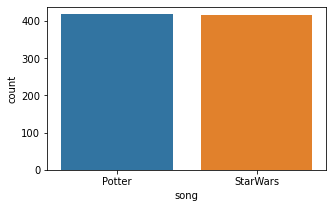

In [9]:
final_df=MLENDHW_df.replace({'song' :{'potter':'Potter','Potter ':'Potter','Starwars':'StarWars','star wars':'StarWars','starwar':'StarWars','starwars':'StarWars','StarsWars':'StarWars','StatWars':'StarWars','STARWARS':'StarWars','StartWars':'StarWars'}})

classes=final_df['song'].value_counts().to_frame()
print(final_df['song'].value_counts())
plt.figure(figsize=(5,3))
sns.countplot(x="song", data=final_df)

plt.show()

The dataset that was given to us is a balanced dataset,As can be seen from the above Countplot.

1)The Number of Data points that belong to class 'Potter' is 417

2)The Number of Data points that belong to class 'StarWars' is 415

# Feature extraction : Pitch

Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D temporal grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

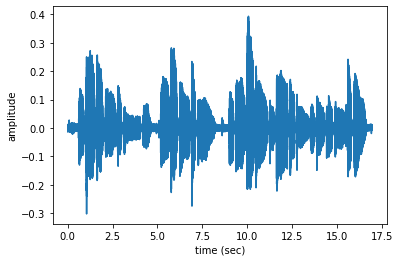

In [10]:
n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

Can you recognise the song and interpretation type? Does it agree with the values shown in the ``` MLENDHW_df ``` dataframe? Let's check it:

In [11]:
final_df.loc[files[n].split('/')[-1]]

participant          S54
interpretation       hum
number                 2
song              Potter
Name: S54_hum_2_Potter.wav, dtype: object

In [12]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 748187 samples


If we are using a raw audio signal as the input of a machine learning model, we will be operating in a predictor space consisting of hundreds of thousands of dimensions. When dealing with the higher dimensional data we have a problem of curse of dimensionality. The more the number of features/dimensions, the more the chances of overfitting, resulting in poor performance on the real data.

One approach to deal with this huge dimensionality is to extract a few features from our signals and use these features as predictors instead. In this notebook we will use four audio features, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In [13]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
    p = winLen*fs
    frame_length = int(2**int(p-1).bit_length()) 
    hop_length = frame_length//2
    f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
    return f0,voiced_flag

Let's consider the problem of identifying the type of interpretation of one of the audio recordings. Then next cell defines a function that takes a number of files and creates a NumPy array containing the 4 audio features used as predictors (`X`) and a binary label (`y`), that indicates whether the type of interpretation is a Potter (`y=1`) or StarWars (`y=0`).

In [14]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    for file in tqdm(files):
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
    #print(file_name)
    #print(labels_file.loc[fileID]['interpretation'])
    #print(labels_file.loc[fileID]['interpretation']=='hum')
    #yi = list(labels_file.loc[fileID]['interpretation'])[0]=='hum'
        yi = labels_file.loc[fileID]['song']=='Potter'

        fs = None # if None, fs would be 22050
        x, fs = librosa.load(file,sr=fs)
        if scale_audio: x = x/np.max(np.abs(x))
        f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
        power = np.sum(x**2)/len(x)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)
      
        xi = [power,pitch_mean,pitch_std,voiced_fr]
        X.append(xi)
        y.append(yi)

    return np.array(X),np.array(y)

Let's apply `getXy` to the dataset and obtain the NumPy predictor array (`X`) and a binary label (`y`)

In [15]:
X,y = getXy(files, labels_file=final_df, scale_audio=True, onlySingleDigit=True)

100%|█████████████████████████████████████████| 832/832 [16:56<00:00,  1.22s/it]


In [16]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (832, 4)
The shape of y is (832,)
The labels vector is [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

Taking the extracted values of X and y and saving it in a 'potter_starwars1.csv' file  

In [17]:
df1=pd.DataFrame(X).rename(columns={0:'power',1: 'pitch_mean',2:'pitch_std',3:'voiced_fr'})

In [18]:
df2=pd.DataFrame(y).rename(columns={0:'class'}).astype(int)

In [19]:
df=pd.concat([df1,df2],axis=1)
print(df.shape)
print(df.head())

(832, 5)
      power  pitch_mean  pitch_std  voiced_fr  class
0  0.019726  190.417149  50.864984   0.761286      1
1  0.037506  175.063566  30.942763   0.781818      1
2  0.089318  388.856923  36.096617   0.688919      1
3  0.038379  180.160892  47.528620   0.817925      1
4  0.011944  185.943901  49.430860   0.927045      1


In [20]:
df.to_csv('potter_starwars1.csv',index=False)

In [21]:
extract_data=pd.read_csv('potter_starwars1.csv')
display(extract_data)

power  pitch_mean  pitch_std  voiced_fr  class
0    0.019726  190.417149  50.864984   0.761286      1
1    0.037506  175.063566  30.942763   0.781818      1
2    0.089318  388.856923  36.096617   0.688919      1
3    0.038379  180.160892  47.528620   0.817925      1
4    0.011944  185.943901  49.430860   0.927045      1
..        ...         ...        ...        ...    ...
827  0.017753  231.432478  57.359071   0.774689      0
828  0.026357  179.716635  32.871520   0.871538      0
829  0.058473  186.863335  38.145865   0.843318      0
830  0.012735  378.193942  79.055452   0.588897      0
831  0.054217  353.453569  61.151190   0.835498      0

[832 rows x 5 columns]

The statistical summaries for each feature

In [22]:
extract_data[['power','pitch_mean','pitch_std','voiced_fr']].describe()

power  pitch_mean   pitch_std   voiced_fr
count  832.000000  832.000000  832.000000  832.000000
mean     0.039859  265.924998   42.129569    0.733371
std      0.045685  101.583913   15.506485    0.133324
min      0.000976  102.898331   11.423941    0.021037
25%      0.019906  173.281838   31.016347    0.667696
50%      0.029982  246.502072   38.851988    0.755276
75%      0.045047  380.493356   51.428440    0.828106
max      0.543047  434.677674  111.753268    0.967517

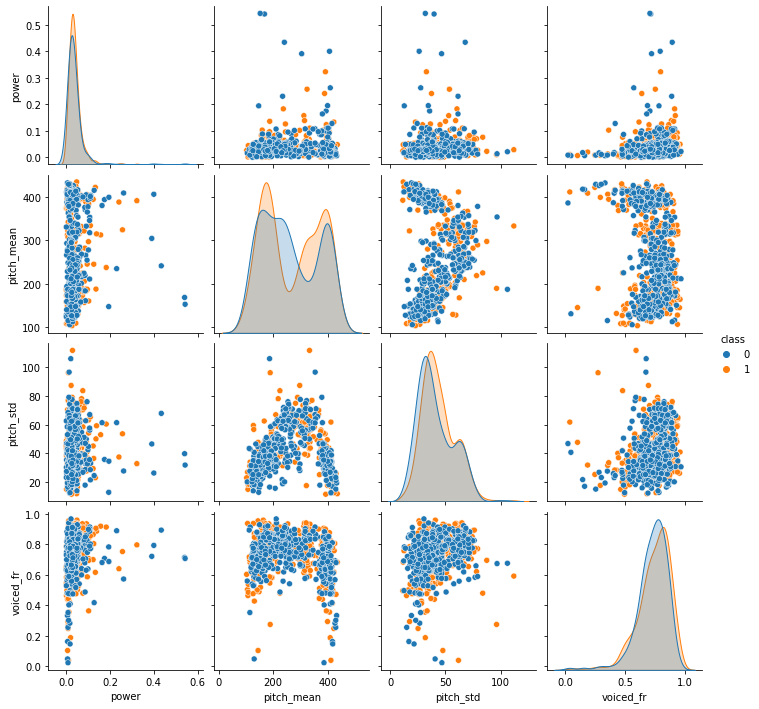

In [23]:
sns.pairplot(extract_data,hue='class')

As can be seen from the above pairplot that the data is not linearly separable

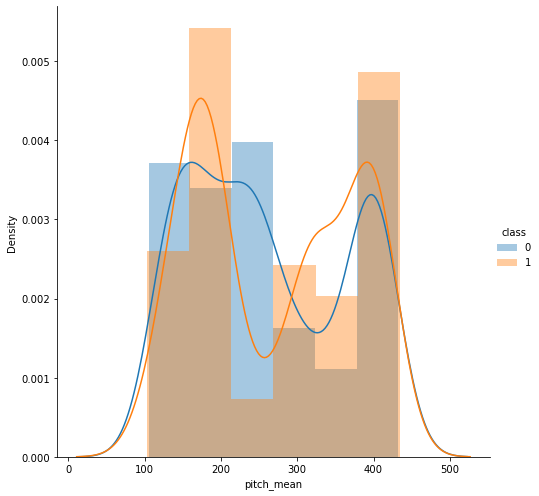

In [24]:
import warnings
warnings.filterwarnings("ignore")

c=['power','pitch_mean','pitch_std','voiced_fr']
for i in c:
    sns.FacetGrid(extract_data,hue='class',size=7).map(sns.distplot,i).add_legend()

As can be seen from the above pdf plot each feature follows different distibution.

1)pdf plot of the power feature has a positive skew

2)pdf plot of fraction of voiced region has a left skew

# Modeling: Support Vector Machines

Let's build a support vector machine (SVM) model for the predictive task of identifying the class label (Potter/StarWars) from an audio signal, using the dataset that we have just created.

Splitting the data into train and validate data set 

Training 80% and CV 20%

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((665, 4), (167, 4), (665,), (167,))

In [26]:
from sklearn import svm
model  = svm.SVC(C=1,random_state=10)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.5533834586466165
Validation  Accuracy 0.5808383233532934
The support vectors are (646, 4)


In [27]:
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=1,gamma=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))
print('The support vectors are', model.support_vectors_.shape)

Training Accuracy 0.7954887218045112
Validation  Accuracy 0.6467065868263473
The support vectors are (542, 4)


Training models like GaussianNB, DecisionTreeClassifier, KneighboursClassifier, RandomForestClassifier, QuadraticDiscriminantAnalyser, AdaBoostClassifier with SVC model (kernel = RBF). Finding the best model with higher accuracy

In [28]:
mean = X_train.mean(0)


sd =  X_train.std(0)


from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

#Standardisation of the dataset

X_train = (X_train-mean)/sd 
X_val  = (X_val-mean)/sd

classification_models = [
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         KNeighborsClassifier(),
                         RandomForestClassifier(),
                         SVC(kernel='rbf'),
                         AdaBoostClassifier(),
                         QuadraticDiscriminantAnalysis()
]
scores = []
for model in classification_models:
    model.fit(X_train,y_train)
    score=model.score(X_val,y_val)
    model_name=type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name='RBF kernel'
    scores.append((model_name,(f'{100*score:.3f}%')))
    scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
    a=scores_df.sort_values(by = 'Accuracy Score',axis = 0, ascending = False)
display(a)

Classifier Accuracy Score
5             AdaBoostClassifier        66.467%
1         DecisionTreeClassifier        64.671%
3         RandomForestClassifier        63.473%
2           KNeighborsClassifier        60.479%
4                     RBF kernel        60.479%
0                     GaussianNB        49.102%
6  QuadraticDiscriminantAnalysis        46.108%

In [29]:
from sklearn.model_selection import cross_validate

Model_name = []
accuracy = []

for model in classification_models:
    cv_results = cross_validate(model, X, y, cv=10)
    model_name=type(model).__name__
   
    #print(model_name,cv_results['test_score'])
    
    acc= np.average(cv_results['test_score'])
    Model_name.append(model_name)
    accuracy.append(acc)


df_crossvalidate = pd.DataFrame(data = accuracy,index = Model_name,columns=['Accuracy'] )
b = df_crossvalidate.sort_values(by = 'Accuracy',axis = 0, ascending = False)
display(b)

Accuracy
AdaBoostClassifier             0.646687
RandomForestClassifier         0.646572
KNeighborsClassifier           0.641824
DecisionTreeClassifier         0.600961
SVC                            0.563669
GaussianNB                     0.516925
QuadraticDiscriminantAnalysis  0.508462

It is observed that the AdaBoostClassifier has the highest training and validate accuracies among all the models

# Modeling: AdaBoostClassifier

In [30]:
#grid search key hyperparameters for adaboost 

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()

# defining the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# defining  the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# defining the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarizing the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarizing all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.651439 using {'learning_rate': 0.1, 'n_estimators': 500}
0.546500 (0.047102) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.544492 (0.047499) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.544492 (0.047499) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.544894 (0.047120) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.544492 (0.047499) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.544894 (0.047120) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.543689 (0.047937) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.552099 (0.047986) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.543689 (0.047937) with: {'learning_rate': 0.01, 'n_estimators': 10}
0.551702 (0.047676) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.583682 (0.057475) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.638239 (0.052223) with: {'learning_rate': 0.01, 'n_estimators': 500}
0.587349 (0.053292) with: {'learning_rate': 0.1, 'n_estimators': 10}
0.635026

In [31]:
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=500,learning_rate=0.1)
classifier.fit(X_train,y_train)

AdaBoostClassifier(learning_rate=0.1, n_estimators=500)

In [32]:
predictions = classifier.predict(X_val)

              precision    recall  f1-score   support

       False       0.75      0.62      0.68        90
        True       0.63      0.75      0.69        77

    accuracy                           0.68       167
   macro avg       0.69      0.69      0.68       167
weighted avg       0.69      0.68      0.68       167



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

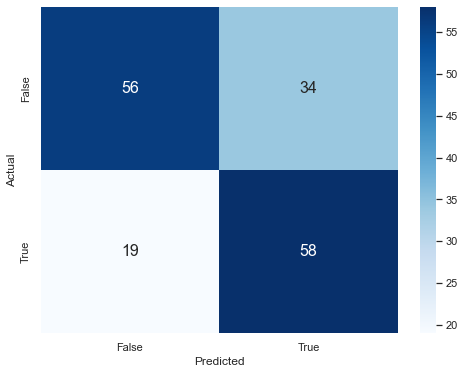

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

conf_matr=confusion_matrix(y_val, predictions)

# Printing the Classification Report
print(classification_report(y_val,predictions))
df_cm = pd.DataFrame(conf_matr, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1.0)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

As can be seen from the above confusion matrix that our model is giving True positive 58 out of 92 times, which is 63% of times it's predicting the class label 'Potter' correctly.

Also it's right in pridicting the class 'StarWars' 56 out of 75 times, i.e 74% of times it's pridicting it's class correctly.

# Conclusions


1) Some advance featurisation techniques in audio processing with the help of domain expert can be used to improve the model accuracies even more further.

2) Training the Model with more number of the data,with Deep learning model, which can be used to improve the accuracies, but we should keep in mind that DL model easily overfit.

# 2
Advanced solution [10 marks]: There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd Hums and Whistles dataset and build a solution model. (ii) Create a product that uses the functionality provided by a model trained on the MLEnd Hums and Whistles dataset (e.g. a simple App that predicts the label Harry or StarWars when you hum to it).

1)For the advance solution I've Built a web app 'Streamlit', which predicts the class label given the test data.

In the Zip file please find along with this notebook - Mini_Project.py and potter_starwars.csv file

Note: Test Data used for this Model is CrossValidate dataset.

Requirements: Please install streamlit using the command !pip3 install streamlit

The way to Run this WebApp is:
i)Go to terminal and type streamlit run Mini_Project.py

ii)After the web app is opened on your safari/chrome tab, when you start scrolling down it will throw an error but actually it's not! from the multiselect options you need to select atleast two parameters for each hyperparameter. 

The main reason for me to choose this Web App is it's quite interactive.

Note:

The reason why I couldn't deploy it is just because, To deploy it I need to keep my Github public. And also I want to do some changes to it,train a deeplearning model and then deploy it. 